In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# 共通関数のロード
import sys
sys.path.append("../../lib/")

from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Common Library for PyTorch
Author: M. Akaishi


In [7]:
# transforms
# 検証データ用
test_transform = transforms.Compose([
    # 画像全体をいったん256*256に
    transforms.Resize(256),
    # 中央の224*224をくり抜く
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
])

# 訓練データ用
train_transform = transforms.Compose([
    # resizeとくり抜きの位置に乱数の要素が入る
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [8]:
data_dir = "hymenoptera_data"

import os
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "val")

print(train_dir, test_dir)
classes = ["ants", "bees"]

hymenoptera_data\train hymenoptera_data\val


In [9]:
train_data = datasets.ImageFolder(
    train_dir,
    transform=train_transform,
)
train_data2 = datasets.ImageFolder(
    train_dir,
    transform=test_transform,
)

test_data = datasets.ImageFolder(
    test_dir,
    transform=test_transform,
)

In [10]:
print(len(train_data))
print(len(test_data))

244
153


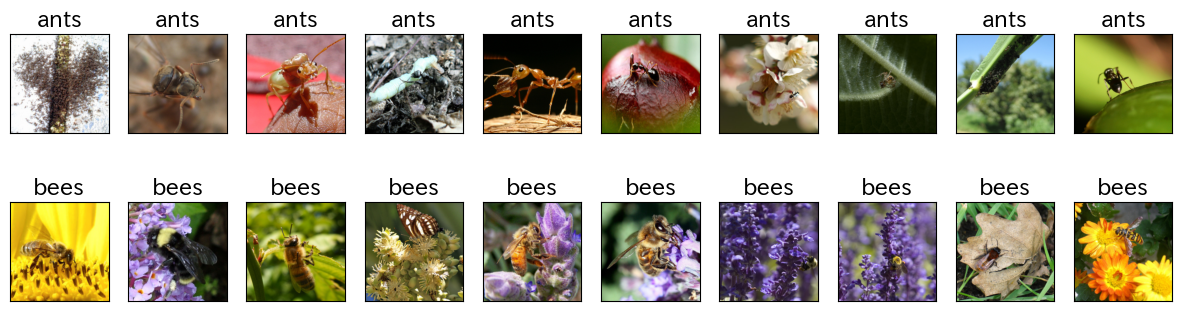

In [11]:
# 検証データ　
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
# データローダー
batch_size = 10

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

# イメージ表示用
train_loader2 = DataLoader(
    train_data2,
    batch_size=50,
    shuffle=True,
)

test_loader2 = DataLoader(
    test_data,
    batch_size=50,
    shuffle=True,
)

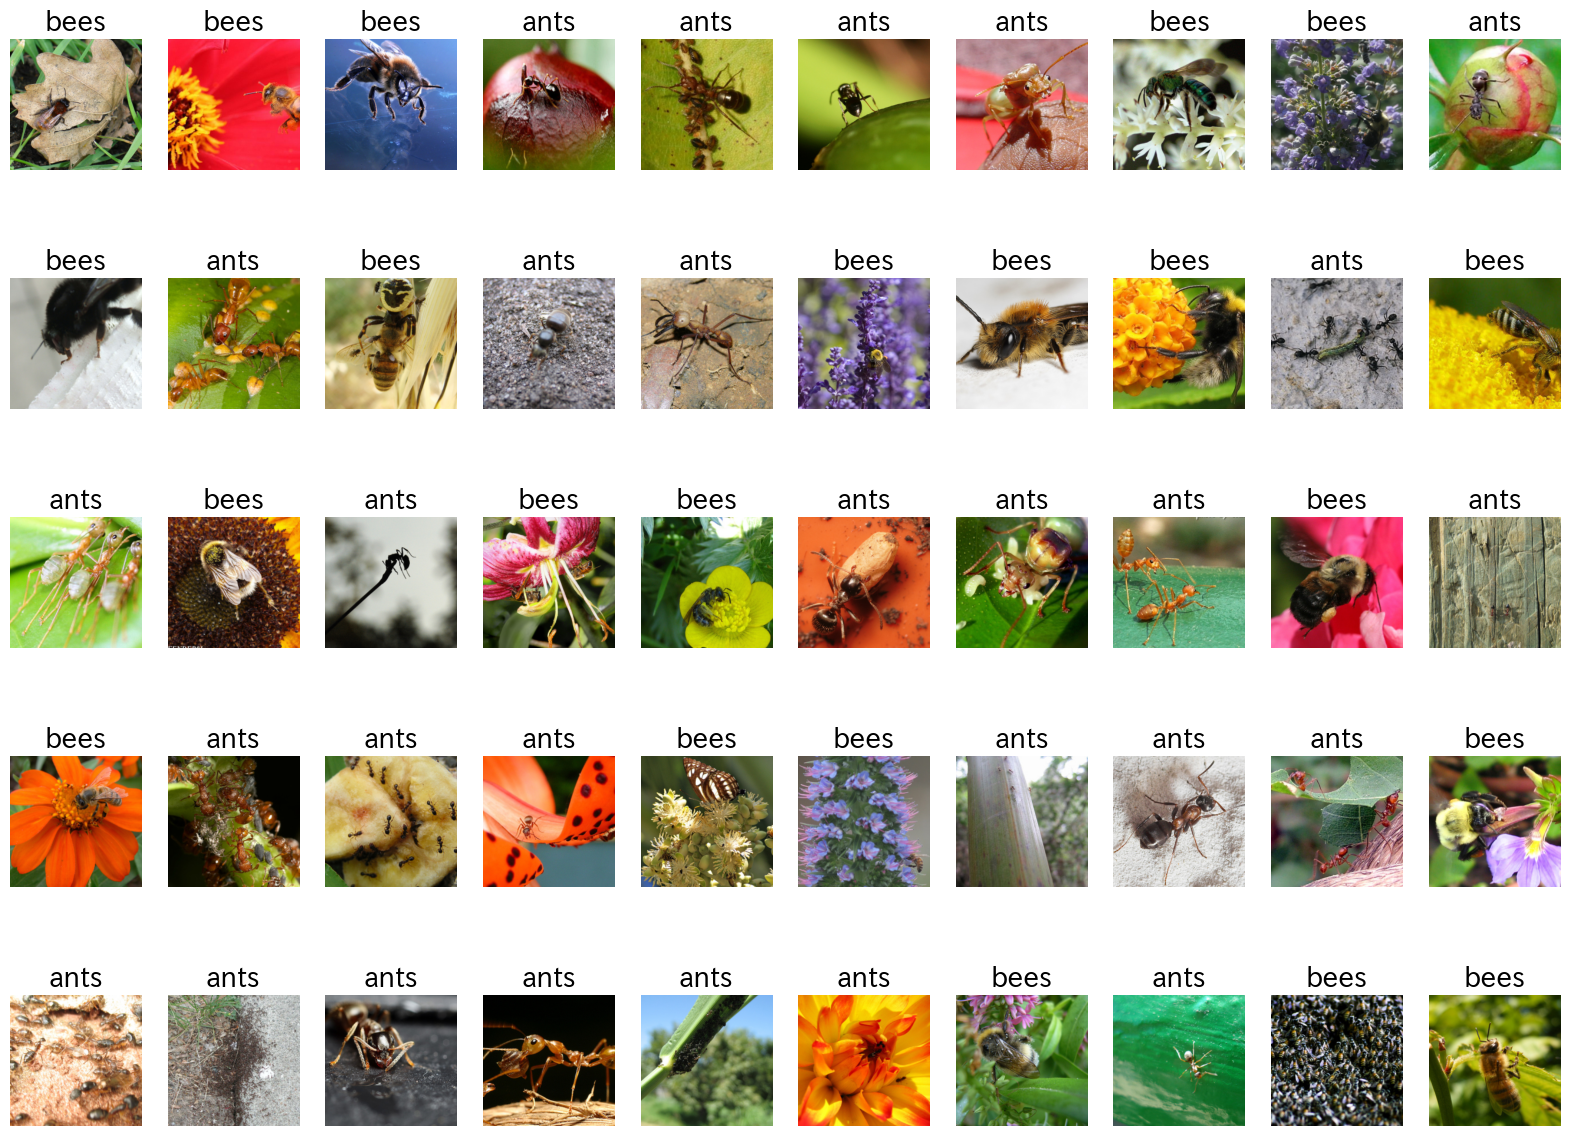

In [13]:
# 検証用データ(50件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

In [14]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

In [15]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [17]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.42795 acc: 0.78689 val_loss: 0.11145, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.18229 acc: 0.92623 val_loss: 0.12577, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.20865 acc: 0.90984 val_loss: 0.11430, val_acc: 0.97386


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.13611 acc: 0.93443 val_loss: 0.16141, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.14178 acc: 0.93443 val_loss: 0.11468, val_acc: 0.96732


初期状態: 損失: 0.11145 精度: 0.96078
最終状態: 損失: 0.11468 精度: 0.96732


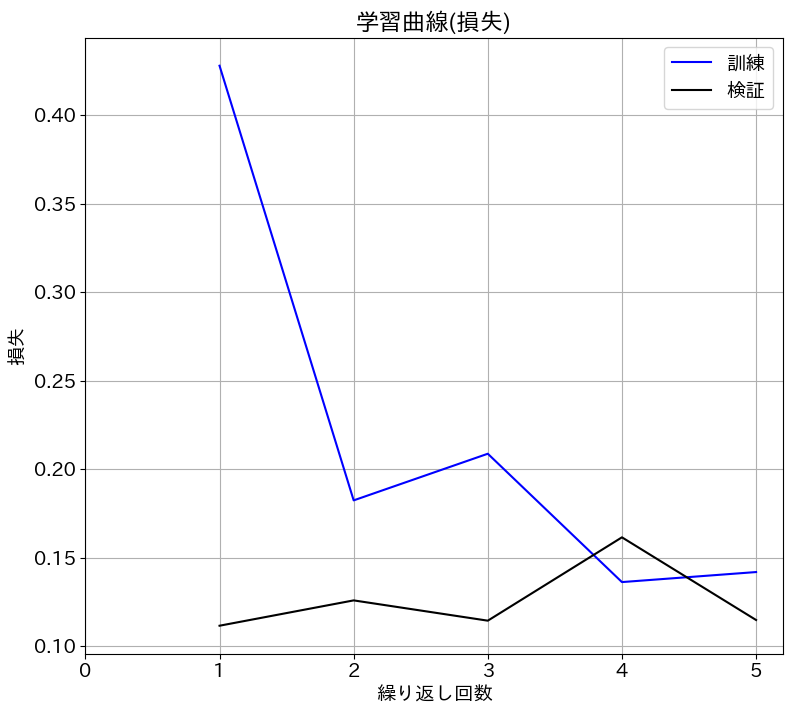

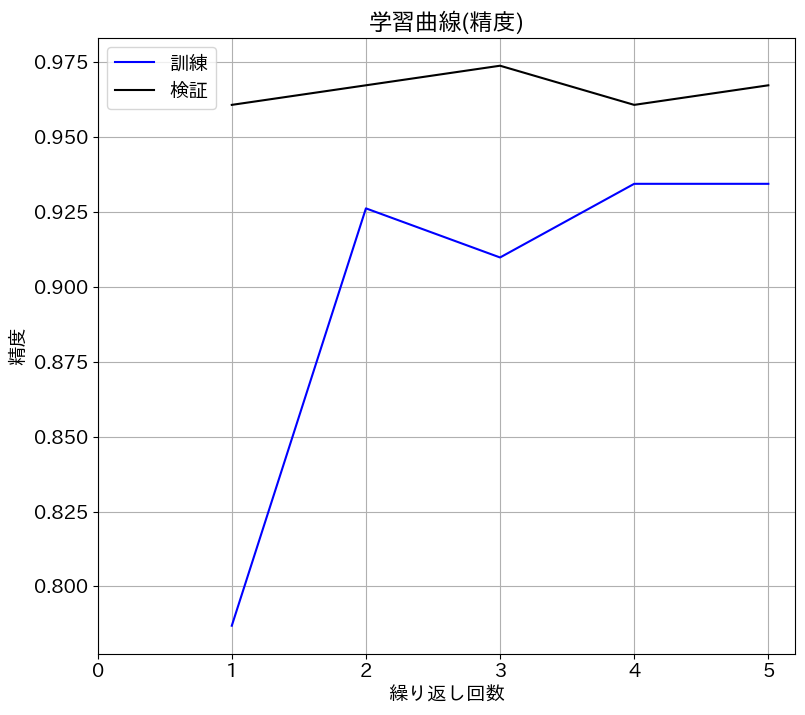

In [18]:
# 結果確認
evaluate_history(history)

In [19]:
# 転移学習
# 学習データが少ない場合は転移学習が向く
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 学習済モデルの既存レイヤの勾配計算をなしに
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# パラメタ修正対象を最終ノードのみに
optimizer = optim.SGD(
    net.classifier[6].parameters(),
    lr=lr,
    momentum=0.9
)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [20]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.44875 acc: 0.78279 val_loss: 0.13660, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.22087 acc: 0.91803 val_loss: 0.12674, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.24330 acc: 0.90164 val_loss: 0.11816, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.20167 acc: 0.90164 val_loss: 0.12738, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.20411 acc: 0.88934 val_loss: 0.11902, val_acc: 0.96078


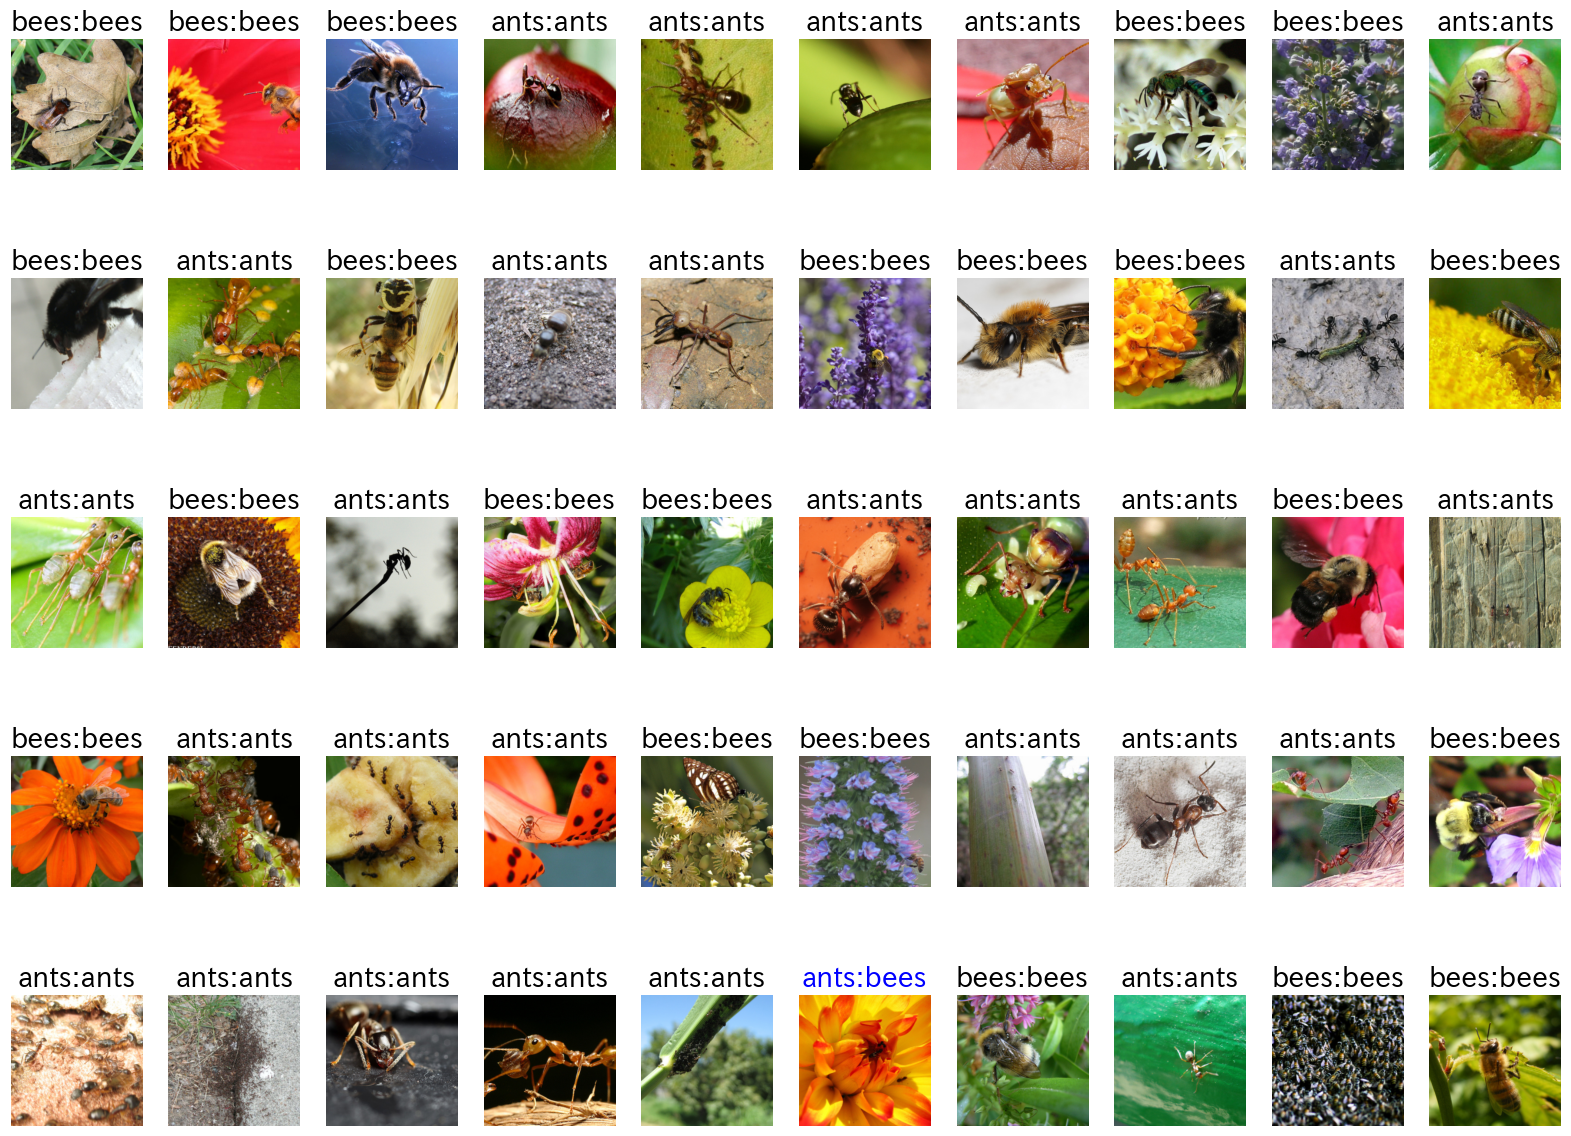

In [21]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)